In [1]:
# load packages
using Distributions
using Random 
using PyPlot
using LinearAlgebra
using Printf
using BenchmarkTools

# load ram updating step  
include("ram_update.jl")

RAM_updating!

In [2]:
# set seed
Random.seed!(1); 

Set model (2d Gaussian with known cov matrix)

In [3]:
a = rand(2,2)
Σ_known = 2*a*a'
μ_real = [0.5;0.7]
model = MvNormal(μ_real, Σ_known)

FullNormal(
dim: 2
μ: [0.5, 0.7]
Σ: [0.306995 0.168526; 0.168526 0.240273]
)


Sample obs data

In [4]:
n = 100
data = rand(model, n)

2×100 Array{Float64,2}:
 0.0351195  1.77164   0.793639  0.823416  …  0.857434  -0.379936  0.667818
 0.564392   0.526612  1.02703   1.24782      1.62883    0.33127   0.753005

Plot obs data

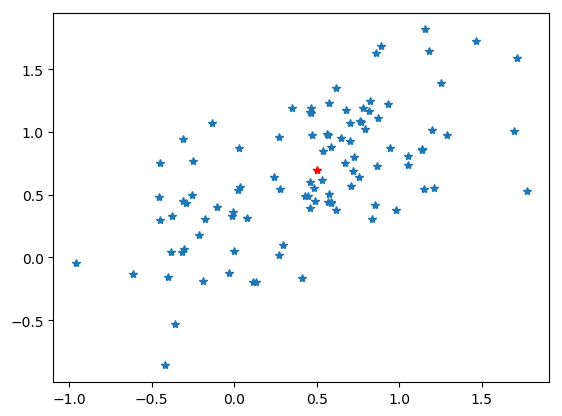

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f846bbb1320>

In [5]:
PyPlot.figure()
PyPlot.plot(data[1,:], data[2,:], "*")
PyPlot.plot(μ_real[1], μ_real[2], "*", color = "red")

Set prior (also MvGaussian since we have a conj model)

In [6]:
Σ_0 = [2. 0; 0 2.]
μ_0 = [0; 0]
Σ_inv_0 = inv(Σ_0)

prior = MvNormal(μ_0, Σ_0)

FullNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [2.0 0.0; 0.0 2.0]
)


Calc analytical post

In [7]:
Σ = cov(data, dims = 2)
Σ_inv = inv(Σ)
x_bar = mean(data, dims = 2)

μ_post = inv((Σ_inv_0 + n*Σ_inv))*(Σ_inv_0*μ_0 + n*Σ_inv*x_bar)
Σ_post = inv((Σ_inv_0 + n*Σ_inv))

post = MvNormal(vec(μ_post), Σ_post)

FullNormal(
dim: 2
μ: [0.446528, 0.662344]
Σ: [0.00318103 0.00179583; 0.00179583 0.00258648]
)


Sample from analytical post

In [8]:
post_analytical_samples = rand(post, 100000)

2×100000 Array{Float64,2}:
 0.410906  0.332461  0.391724  0.495704  …  0.512204  0.436369  0.433235
 0.666975  0.569185  0.559315  0.623464     0.739212  0.655408  0.69009 

Plot analytical post

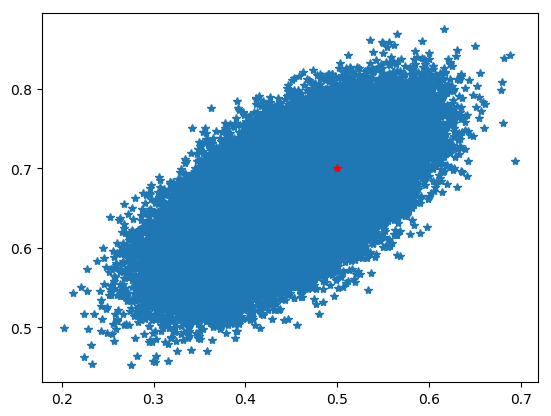

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f846bb79630>

In [9]:
PyPlot.figure()
PyPlot.plot(post_analytical_samples[1,:], post_analytical_samples[2,:], "*")
PyPlot.plot(μ_real[1], μ_real[2], "*", color = "r")

MCMC sampler 

In [10]:
# MH sampler  
function mcmc(R, Σ_prop, adapt=false)

    samples = zeros(2,R)
    loglik = zeros(R)
    
    μ_start = [0;0]
    loglik[1] = logpdf(post, μ_start)
    samples[:,1] = μ_start

    for r in 2:R

        u = randn(2)    
        μ_star = samples[:,r-1] + Σ_prop.L*u
        
        logpdf_star = logpdf(post, μ_star)
        
        logα_curr = logpdf_star - loglik[r-1]
                    
        if log(rand()) < logα_curr
            samples[:,r] = μ_star
            loglik[r] = logpdf_star
        else
            samples[:,r] = samples[:,r-1]
            loglik[r] = loglik[r-1]
        end

        if adapt == true && r > 100 
            α_curr = min(1, exp(logα_curr)) # adapt Σ_prop
            RAM_updating!(Σ_prop, u, α_curr, r, 2)
        end
            
    end 
            
    return samples, loglik 
end


mcmc (generic function with 2 methods)

Run MCMC without adaptation 

In [11]:
R = 100000
Σ_prop = cholesky(2.4/sqrt(2)*[1 0 ; 0 1])

Cholesky{Float64,Array{Float64,2}}
U factor:
2×2 UpperTriangular{Float64,Array{Float64,2}}:
 1.30271  0.0    
  ⋅       1.30271

In [12]:
samples_no_adapt, loglik_no_adapt = @time mcmc(R,Σ_prop,false)
@printf "Accaptance rate:  %.4f %%\n" length(unique(loglik_no_adapt))/R*100

  1.469459 seconds (4.67 M allocations: 253.575 MiB, 12.65% gc time)
Accaptance rate:  0.2470 %


In [13]:
@benchmark mcmc(R,Σ_prop,false)

BenchmarkTools.Trial: 
  memory estimate:  133.49 MiB
  allocs estimate:  2299982
  --------------
  minimum time:     279.383 ms (8.02% GC)
  median time:      295.882 ms (7.76% GC)
  mean time:        308.371 ms (11.16% GC)
  maximum time:     434.735 ms (27.89% GC)
  --------------
  samples:          17
  evals/sample:     1

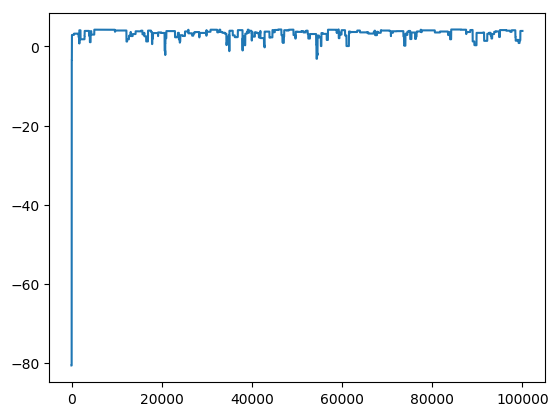

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f846bb4e8d0>

In [14]:
PyPlot.figure()
PyPlot.plot(loglik_no_adapt)

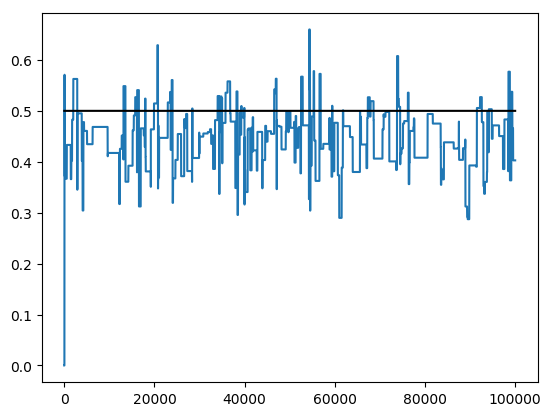

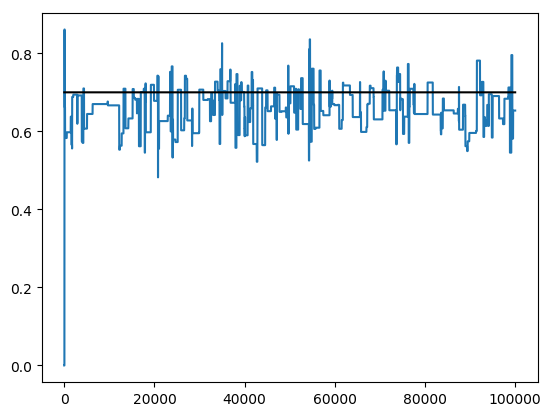

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f846bae1550>

In [15]:
PyPlot.figure()
PyPlot.plot(samples_no_adapt[1,:])
PyPlot.plot(μ_real[1]*ones(R), "black")
PyPlot.figure()
PyPlot.plot(samples_no_adapt[2,:])
PyPlot.plot(μ_real[2]*ones(R), "black")

Run MCMC with RAM adaptation

In [16]:
samples_adapt, loglik_adapt = @time mcmc(R,Σ_prop,true)
@printf "Accaptance rate:  %.4f %%\n" length(unique(loglik_adapt))/R*100

  0.812576 seconds (3.88 M allocations: 213.394 MiB, 5.60% gc time)
Accaptance rate:  22.8370 %


In [17]:
@benchmark mcmc(R,Σ_prop,true)

BenchmarkTools.Trial: 
  memory estimate:  194.21 MiB
  allocs estimate:  3498249
  --------------
  minimum time:     442.911 ms (7.99% GC)
  median time:      463.985 ms (7.78% GC)
  mean time:        470.344 ms (9.42% GC)
  maximum time:     580.954 ms (22.81% GC)
  --------------
  samples:          11
  evals/sample:     1

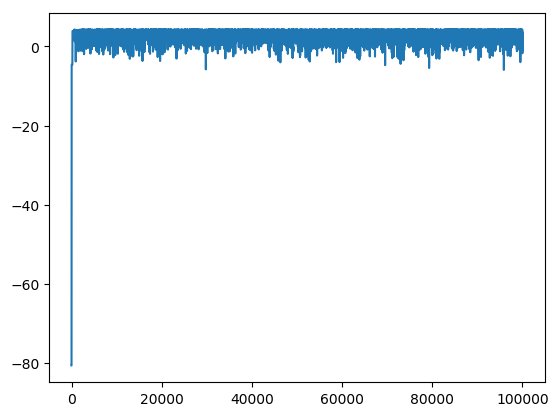

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f846b868a20>

In [18]:
PyPlot.figure()
PyPlot.plot(loglik_adapt)

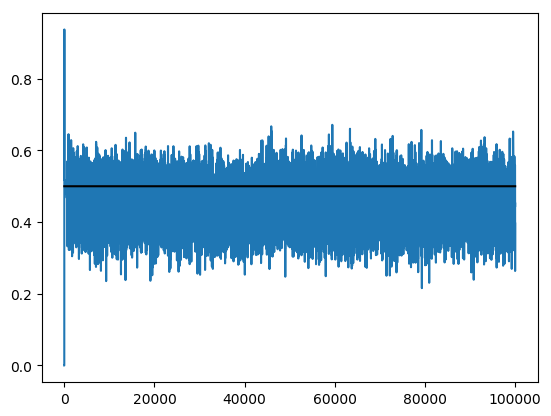

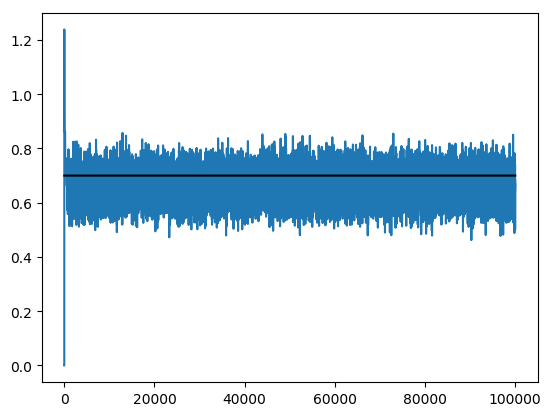

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f846b868f28>

In [19]:
PyPlot.figure()
PyPlot.plot(samples_adapt[1,:])
PyPlot.plot(μ_real[1]*ones(R), "black")
PyPlot.figure()
PyPlot.plot(samples_adapt[2,:])
PyPlot.plot(μ_real[2]*ones(R), "black")

Plot posteriors 

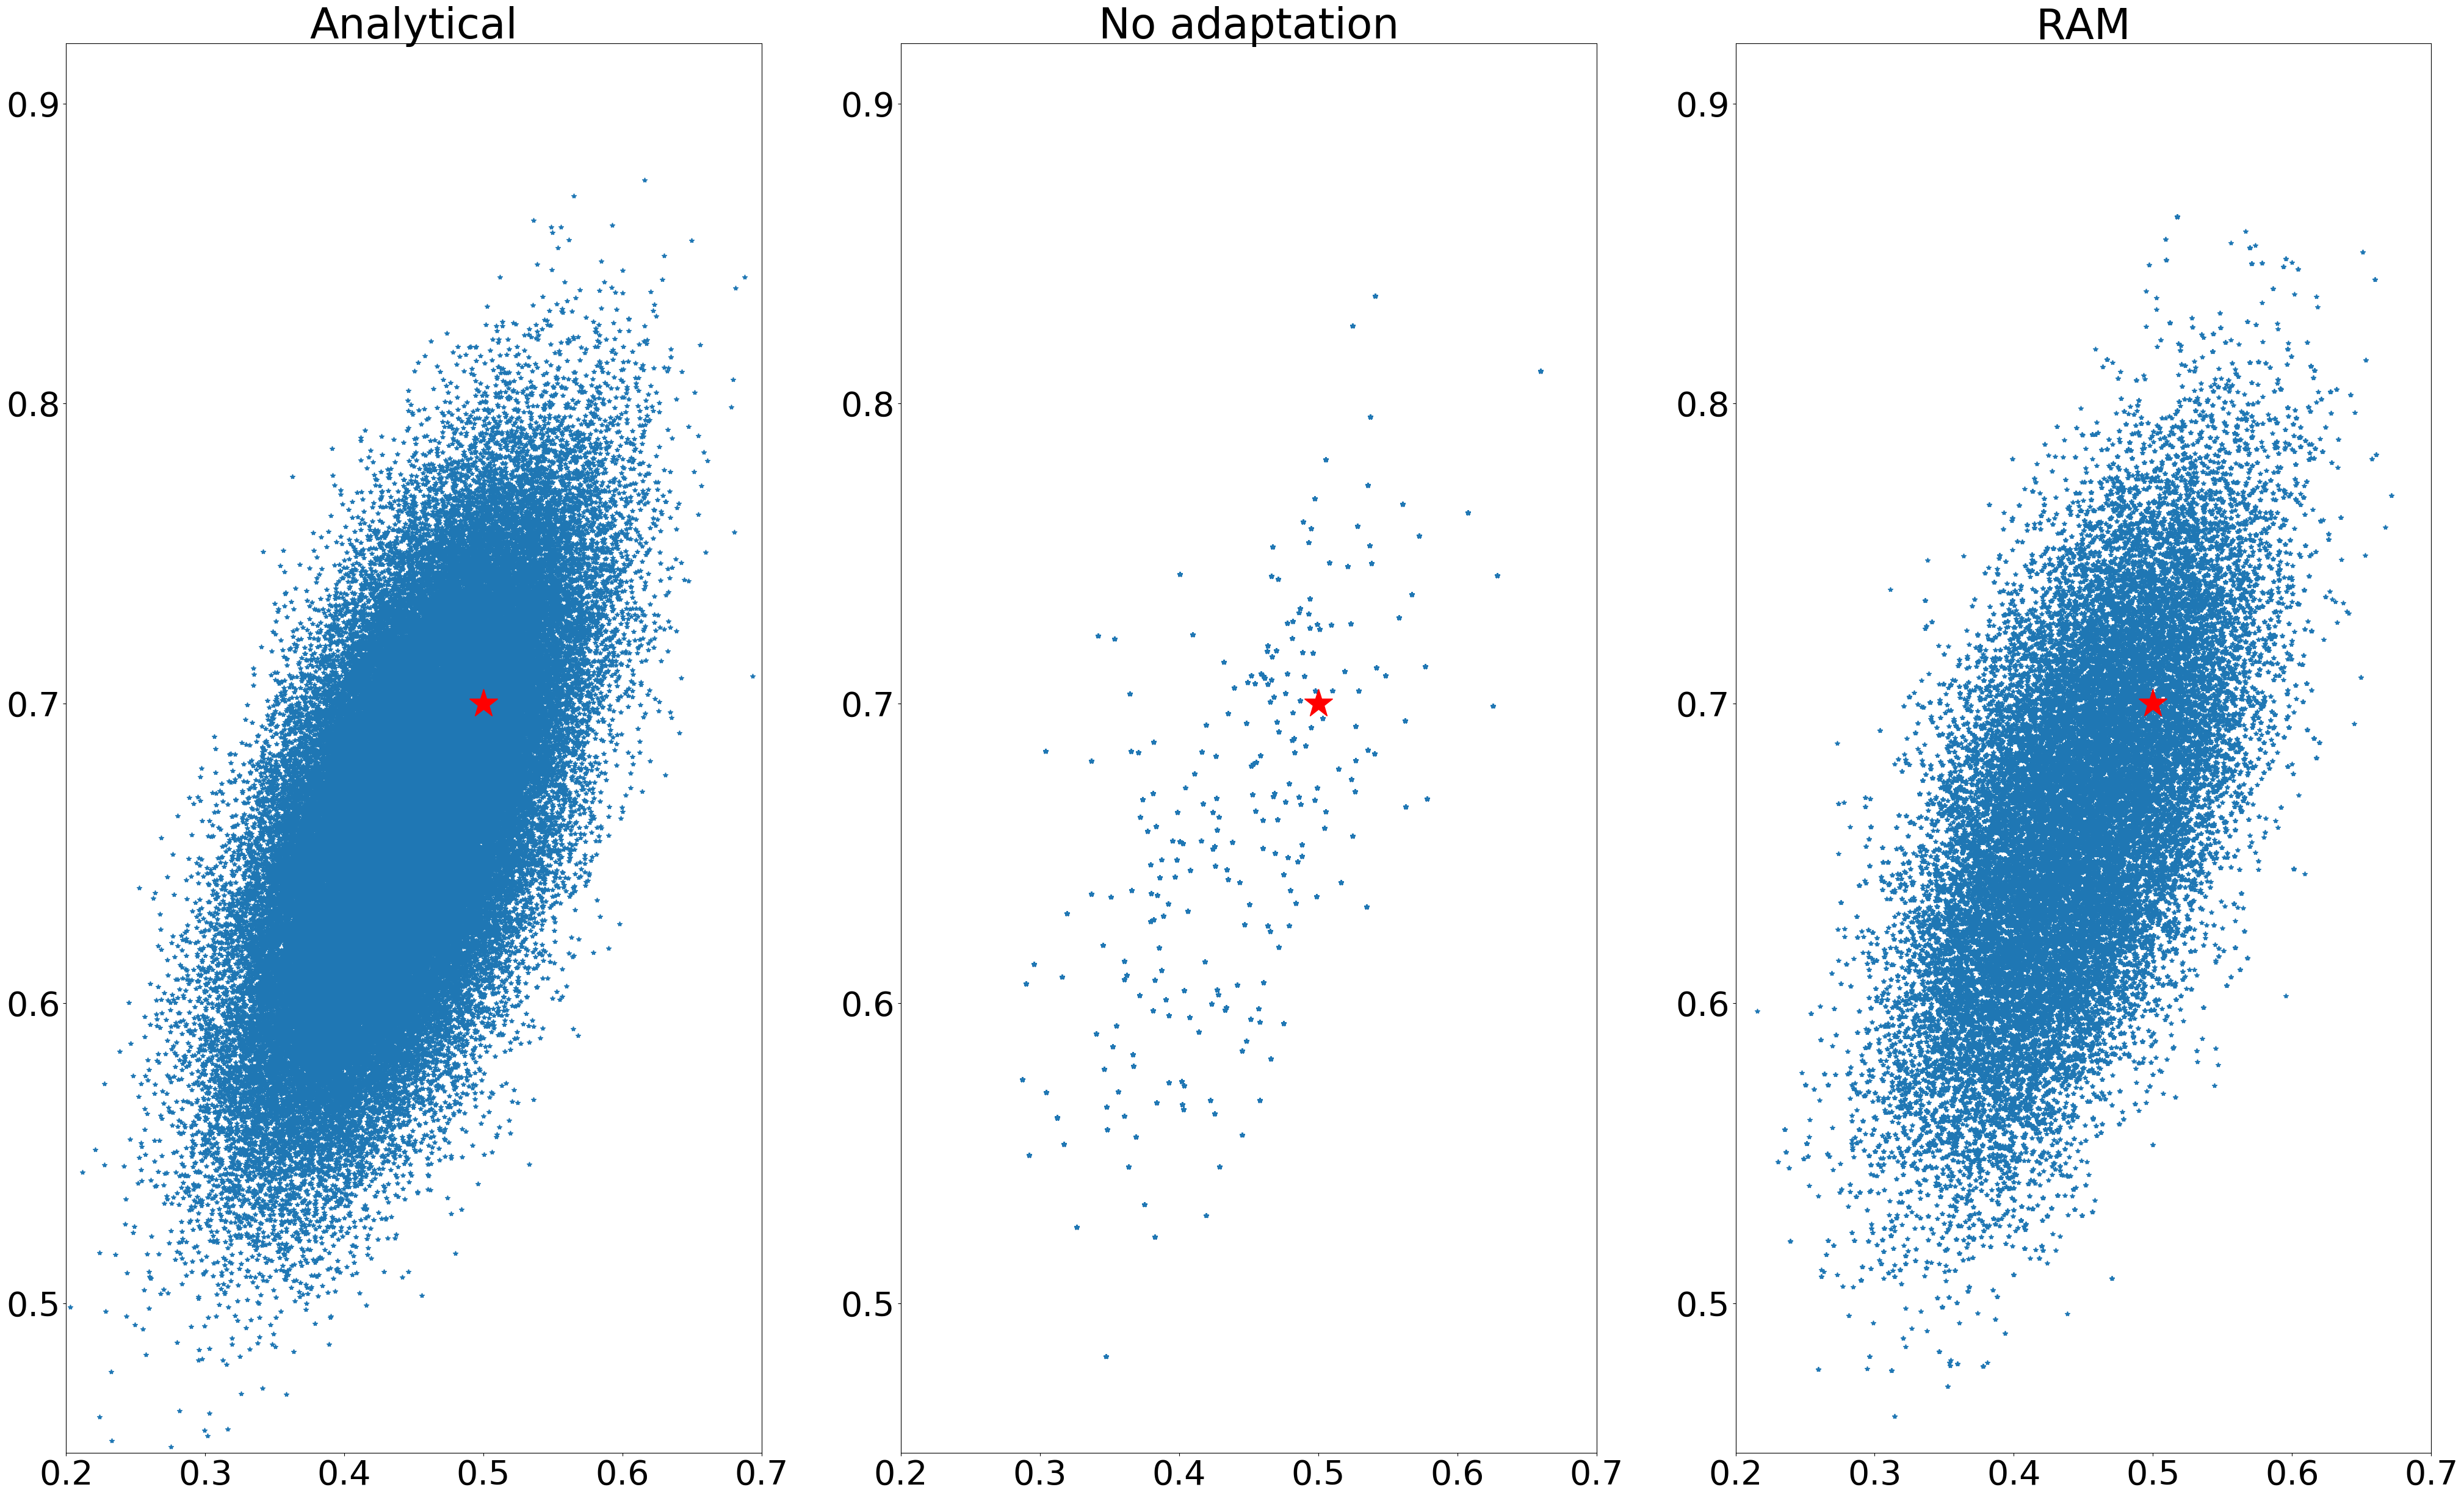

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[23]:9
└ @ Core In[23]:9
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[23]:10
└ @ Core In[23]:10
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[23]:11
└ @ Core In[23]:11
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[23]:12
└ @ Core In[23]:12
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in fav

In [23]:
fig = PyPlot.figure(figsize = (50,30))

ax1 = PyPlot.subplot(1, 3, 1)
ax2 = PyPlot.subplot(1, 3, 2)#, sharex=ax1)
ax3 = PyPlot.subplot(1, 3, 3)#, sharex=ax1)

ax1.plot(post_analytical_samples[1,:], post_analytical_samples[2,:], "*")
ax1.plot(μ_real[1], μ_real[2], "*", color = "red",markersize = 35)
ax1[:tick_params](axis="both", which="major", labelsize=40)
ax1[:set_title]("Analytical", fontsize=50)
ax1[:set_ylim](0.45,0.92)
ax1[:set_xlim](0.2,0.7)

ax2.plot(samples_no_adapt[1,100:end], samples_no_adapt[2,100:end], "*")
ax2.plot(μ_real[1], μ_real[2], "*", color = "red",markersize = 35)
ax2[:tick_params](axis="both", which="major", labelsize=40)
ax2[:set_title]("No adaptation", fontsize=50)
ax2[:set_ylim](0.45,0.92)
ax2[:set_xlim](0.2,0.7)

ax3.plot(samples_adapt[1,100:end], samples_adapt[2,100:end], "*")
ax3.plot(μ_real[1], μ_real[2], "*", color = "red",markersize = 35)
ax3[:tick_params](axis="both", which="major", labelsize=40)
ax3[:set_title]("RAM", fontsize=50)
ax3[:set_ylim](0.45,0.92)
ax3[:set_xlim](0.2,0.7);


In [319]:
mu_real

2-element Array{Float64,1}:
 0.5
 0.7

In [320]:
mean(post_analytical_samples,dims=2)

2×1 Array{Float64,2}:
 0.4364032954569586
 0.7028718689321867